In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from fast_ml.model_development import train_valid_test_split
from sklearn.preprocessing import StandardScaler 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#!pip install xgboost


from sklearn.impute import KNNImputer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from itertools import product
import scipy.stats as ss

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam


from warnings import filterwarnings
filterwarnings('ignore')

# EDA(Exploratory Data Analysis)

In [74]:
df=pd.read_csv('311-DSNY-20151017.csv')
df

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,29653961,01/07/2015 06:50:12 PM,NaN,DSNY,Department of Sanitation,Graffiti,Graffiti,NaN,NaN,10 s4 st,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29655441,01/07/2015 08:17:00 AM,01/07/2015 12:00:00 PM,DSNY,BCC - Queens East,Snow,15S Re-Plow/Spread/Ice-Snow Cond.,Street,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29750581,01/19/2015 05:00:00 PM,01/21/2015 12:00:00 PM,DSNY,BCC - Queens West,Litter Basket / Request,10 Litter Basket / Request,Sidewalk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29767423,01/22/2015 09:21:00 AM,01/31/2015 12:00:00 PM,DSNY,A - Canine Task Force Citywide,Dirty Conditions,E8 Canine Violation,Sidewalk,NaN,QUEENS BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29618799,01/02/2015 06:11:00 AM,01/05/2015 12:00:00 PM,DSNY,Bronx 10,Sanitation Condition,12 Dead Animals,Sidewalk,NaN,HUTCHISON RIVER PKW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576482,38093331,12/29/2017 03:53:00 PM,01/03/2018 12:00:00 PM,DSNY,BCC - Brooklyn North,Other Enforcement,E10 Street Obstruction,Sidewalk,11205.0,105 GRAND AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.694133,-73.964144,"(40.69413344540047, -73.96414420184784)"
576483,38093343,12/31/2017 12:08:00 PM,01/04/2018 12:00:00 PM,DSNY,BCC - Brooklyn North,Litter Basket / Request,10 Litter Basket / Request,Sidewalk,11226.0,2100 BEDFORD AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.653129,-73.956104,"(40.6531292016264, -73.95610427350206)"
576484,32306758,12/31/2015 10:28:00 AM,01/05/2016 12:00:00 PM,DSNY,Queens East 12,Missed Collection (All Materials),1 Missed Collection,Sidewalk,11434.0,179-12 134 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.677703,-73.760024,"(40.67770285755642, -73.76002369489642)"
576485,32308741,12/31/2015 03:13:00 PM,01/06/2016 12:00:00 PM,DSNY,A - Queens,Dirty Conditions,E3A Dirty Area/Alleyway,Lot,11426.0,247-17 88 ROAD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.728623,-73.720484,"(40.728622570989664, -73.72048407679036)"


In [75]:
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

## 1. Drop Duplicated rows &Columns

In [76]:
df=df.drop_duplicates()

In [77]:
#X Coordinate (State Plane) and Longitude correlation have same description
#Y Coordinate (State Plane) and Latitude correlation  have same description
#Park Borough and Borough  have same description
#Drop X Coordinate (State Plane),Y Coordinate (State Plane),Park Borough 
df=df.drop(columns=['X Coordinate (State Plane)','Y Coordinate (State Plane)','Park Borough' ])

## 2. Drop Features with high missing value(higher than 80%)

In [78]:
miss=pd.DataFrame(df.isnull().sum() * 100 / len(df), 
                  columns = ['missing_percentage']).sort_values(by=['missing_percentage'], ascending=False)
miss_80=miss[miss.missing_percentage>=80]
miss_80

,missing_percentage
Vehicle Type,100.000000
Taxi Pick Up Location,100.000000
Bridge Highway Name,100.000000
Bridge Highway Segment,100.000000
Road Ramp,100.000000
Bridge Highway Direction,100.000000
Landmark,100.000000
Taxi Company Borough,100.000000
Due Date,92.617353
Intersection Street 1,85.299755


In [79]:
# Drop the Features with high missing value(higher than 80%)
df=df.drop(columns=miss_80.index)

## 3. Check Cardnality and drop Univarite Features and High Cardnality Categorical Features

In [80]:
#Count number of distinct elements in specified axis.
unique = pd.DataFrame(df.nunique(), columns = ['uniqueness']).sort_values(by=['uniqueness'], ascending=False)
unique['cardnality_percent']=unique.uniqueness/len(df)*100
unique

,uniqueness,cardnality_percent
Unique Key,576487,100.000000
Created Date,386117,66.977573
Location,285656,49.551161
Longitude,285654,49.550814
Latitude,285654,49.550814
Incident Address,265035,45.974150
BBL,225088,39.044766
Resolution Action Updated Date,32635,5.661012
Closed Date,25602,4.441037
Cross Street 1,16991,2.947334


### 3.1 Drop Features with All Same Value(Univariate Features)

In [81]:
#uniqueness==1 means features with all same value
all_same_value_features=unique[unique['uniqueness']==1].index
print(all_same_value_features)
#Drop columns: 'Park Facility Name', 'Facility Type', 'Agency'
df=df.drop(columns=all_same_value_features)

Index(['Agency', 'Park Facility Name', 'Facility Type'], dtype='object')


### 3.2 Drop Categorical Features with high Catrgorical Cardnality 

In [83]:
#After checking all carnality, we drop cardnality percentage is larger than 10%
high_cardnality=unique[unique['cardnality_percent']>1].index
print(high_cardnality)

#Drop columns with high cardnality but expect Date & numerical features
df=df.drop(columns=high_cardnality.drop(['Created Date','Closed Date',
                                         'Latitude', 'Longitude','BBL',
                                         'Resolution Action Updated Date',]))

Index(['Unique Key', 'Created Date', 'Location', 'Longitude', 'Latitude',
       'Incident Address', 'BBL', 'Resolution Action Updated Date',
       'Closed Date', 'Cross Street 1', 'Street Name', 'Cross Street 2'],
      dtype='object')


## 4.Target Variable Analysis & new features from dates

In [84]:
#There are three date left in dataset, first converting these dates to datetime
df['Created Date'] = pd.to_datetime(df['Created Date'],errors = 'coerce')
df['Closed Date'] = pd.to_datetime(df['Closed Date'],errors = 'coerce')
df['Resolution Action Updated Date'] = pd.to_datetime(df['Resolution Action Updated Date'],errors = 'coerce')

In [85]:
df[['Created Date', 'Closed Date','Resolution Action Updated Date']].describe(datetime_is_numeric=True)

,Created Date,Closed Date,Resolution Action Updated Date
count,576487,570241,574641
mean,2016-09-13 11:06:34.389735424,2016-09-25 06:21:52.180774400,2016-09-26 04:26:29.344047872
min,2015-01-01 01:57:00,1900-01-01 00:00:00,2015-01-02 12:00:00
25%,2015-12-01 13:59:00,2015-12-10 12:00:00,2015-12-10 12:00:00
50%,2016-10-17 13:29:00,2016-10-28 12:00:00,2016-10-31 12:00:00
75%,2017-07-18 16:26:30,2017-07-26 12:00:00,2017-07-26 12:45:00
max,2017-12-31 23:50:00,2201-12-05 00:00:00,2021-05-13 09:40:37


### 4.1 There are outliiers in closed Date:
    1. drop those closed date is before created date
    2. drop extreme non-sense outliers 
    3. drop missing closed date rows

In [86]:
#drop those closed date is before created date
df=df[df['Created Date']<df['Closed Date']]

In [87]:
#Extract year from closed date
df['Closed_date_year'] = pd.DatetimeIndex(df['Closed Date']).year

<AxesSubplot:ylabel='Closed_date_year'>

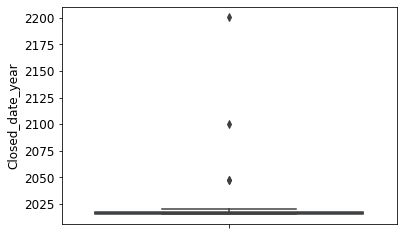

In [88]:
sns.boxplot(y=df["Closed_date_year"])

In [89]:
df['Closed_date_year'].value_counts()

2017    233356
2016    152500
2015    139494
2018      5433
2019       777
2020         3
2047         2
2100         1
2201         1
Name: Closed_date_year, dtype: int64

In [90]:
#Drop non-sense closed date(>2019 year closed date)
df=df[df['Closed_date_year']<2020]

In [91]:
#Drop missing closed date rows
df=df[df['Closed Date'].notnull()]

### 4.2 Plot Histogram of Created & Closed Date

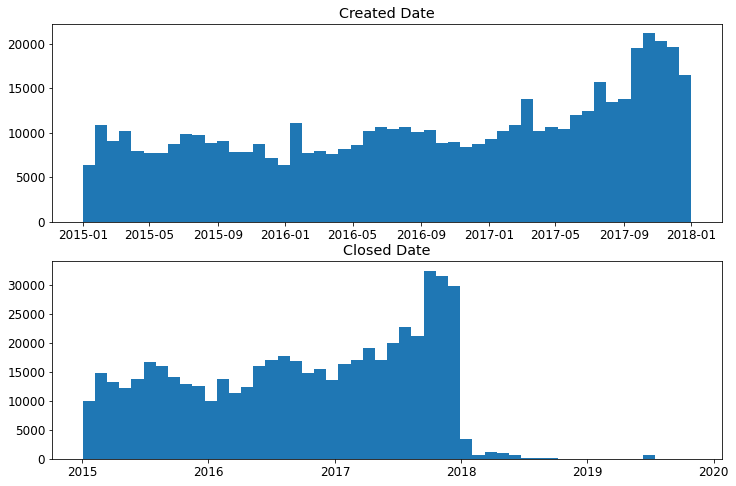

In [92]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2,figsize=(12,8))

axs[0].hist(df['Created Date'],bins=50)
axs[0].set_title('Created Date');
axs[1].hist(df['Closed Date'],bins=50)
axs[1].set_title('Closed Date');

### 4.3 Deriving the Target Variable -- Resolved Time in days

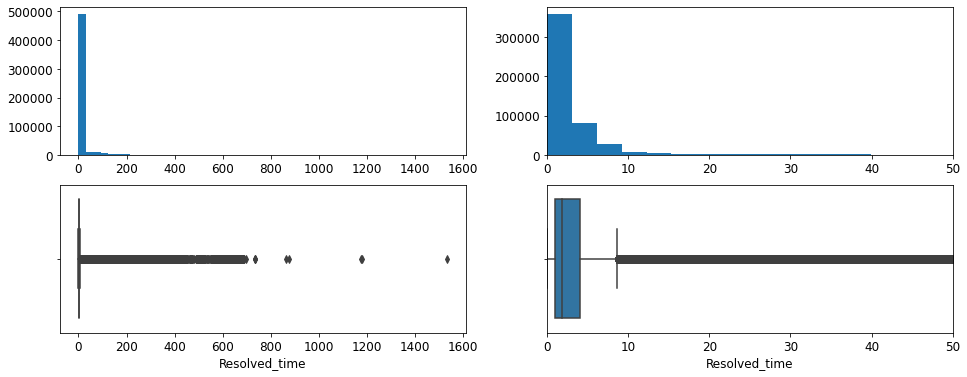

In [93]:
df['Resolved_time'] = (df['Closed Date']-df['Created Date'])/pd.Timedelta(days=1)

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2,2,figsize=(16,6))
axs[0][0].hist(df['Resolved_time'],bins=50)
sns.boxplot(df['Resolved_time'],ax=axs[1][0])

#Zoom in days in the range 50days
axs[0][1].hist(df['Resolved_time'],bins=500)
axs[0][1].set_xlim([0,50])
sns.boxplot(df['Resolved_time'],ax=axs[1][1])
axs[1][1].set_xlim([0,50]);

### 4.4 Deriving Independent Variables from Created & Closed Date

In [94]:
#Extract year & month from closed & Created Date
df['Closed_date_year'] = pd.DatetimeIndex(df['Closed Date']).year
df['Created_date_year'] = pd.DatetimeIndex(df['Created Date']).year
df['Closed_date_month'] = pd.DatetimeIndex(df['Closed Date']).month
df['Created_date_month'] = pd.DatetimeIndex(df['Created Date']).month

In [95]:
df['Resolution_time'] = (df['Resolution Action Updated Date']-df['Created Date'])/pd.Timedelta(days=1)

In [96]:
(df['Resolution_time']-df['Resolved_time']).value_counts()

0.000000     489044
1.000000        103
0.083333         90
9.493067         63
18.637940        63
              ...  
27.513819         1
0.138889          1
16.488079         1
27.411250         1
21.448877         1
Length: 9872, dtype: int64

In [97]:
#Drop Dates
df=df.drop(columns=['Created Date','Closed Date','Resolution Action Updated Date'])

## 5.Missing Value Imputation

In [98]:
pd.DataFrame(df.isnull().sum() * 100 / len(df), 
                  columns = ['missing_percentage']).sort_values(by=['missing_percentage'], ascending=False)

,missing_percentage
BBL,19.408533
Resolution Description,7.964294
Longitude,2.005794
Latitude,2.005794
Incident Zip,1.913613
City,1.904583
Location Type,1.099594
Address Type,0.412559
Borough,0.216344
Community Board,0.216344


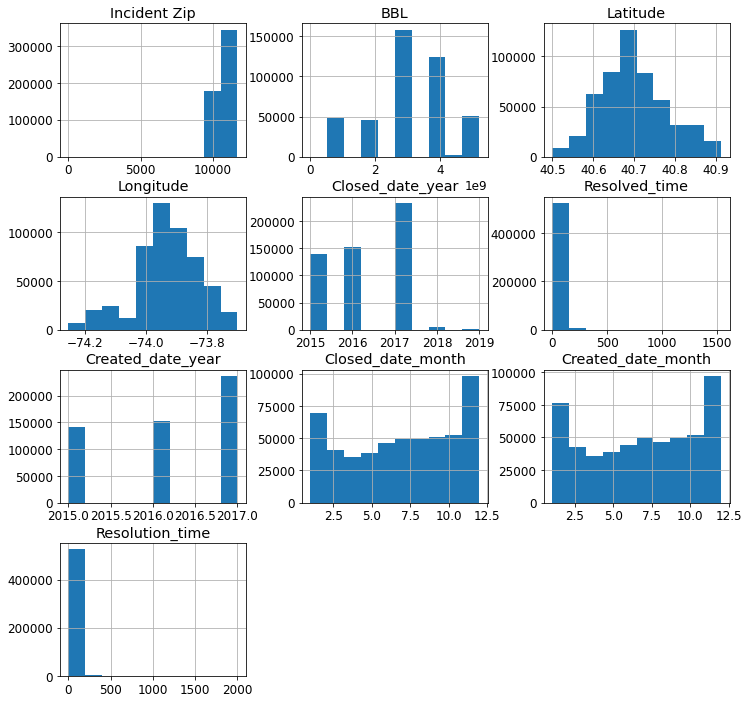

In [110]:
df.hist(figsize=(12,12));

### 5.1 Impute numerical features with mean/median depend on distribution's skewness

In [114]:
df['BBL']=df['BBL'].fillna(df['BBL'].median())
df['Incident Zip']=df['Incident Zip'].fillna(df['Incident Zip'].median())
df['Longitude']=df['Longitude'].fillna(df['Longitude'].mean())
df['Latitude']=df['Latitude'].fillna(df['Latitude'].mean())
df['Resolution_time']=df['Resolution_time'].fillna(df['Resolution_time'].mean())

### 5.1 Impute categorical features with mode(most frequent values)

In [135]:
df['Resolution Description']=df['Resolution Description'].fillna('The Department of Sanitation investigated this complaint and found no violation at the location.')
df['City']=df['City'].fillna('BROOKLYN')
df['Location Type']=df['Location Type'].fillna('Sidewalk')
df['Address Type']=df['Address Type'].fillna('ADDRESS')
df['Borough']=df['Borough'].fillna('BROOKLYN')
df['Community Board']=df['Community Board'].fillna('01 STATEN ISLAND')

In [136]:
pd.DataFrame(df.isnull().sum() * 100 / len(df), 
                  columns = ['missing_percentage']).sort_values(by=['missing_percentage'], ascending=False)

,missing_percentage
Agency Name,0.0
Borough,0.0
Created_date_month,0.0
Closed_date_month,0.0
Created_date_year,0.0
Resolved_time,0.0
Closed_date_year,0.0
Longitude,0.0
Latitude,0.0
Open Data Channel Type,0.0


## 6. Feature Engineering & Drop Multicollinearity Features
    1. Drop High Correlated Categorical Features (using one-hot encoding)
    2. Drop High Correlated Numerical Features 
    

### one-hot encoding for categorical data 

In [138]:
df=pd.get_dummies(df)
df.head()

,Incident Zip,BBL,Latitude,Longitude,Closed_date_year,Resolved_time,Created_date_year,Closed_date_month,Created_date_month,Resolution_time,...,Borough_BROOKLYN,Borough_MANHATTAN,Borough_QUEENS,Borough_STATEN ISLAND,Borough_Unspecified,Open Data Channel Type_MOBILE,Open Data Channel Type_ONLINE,Open Data Channel Type_OTHER,Open Data Channel Type_PHONE,Open Data Channel Type_UNKNOWN
1,11214.0,3.062590e+09,40.699399,-73.932764,2015,0.154861,2015,1,1,0.154861,...,0,0,1,0,0,0,0,0,1,0
2,11214.0,3.062590e+09,40.699399,-73.932764,2015,1.791667,2015,1,1,1.791667,...,0,0,1,0,0,0,0,0,1,0
3,11214.0,3.062590e+09,40.699399,-73.932764,2015,9.110417,2015,1,1,9.110417,...,0,0,1,0,0,0,1,0,0,0
4,11214.0,3.062590e+09,40.699399,-73.932764,2015,3.242361,2015,1,1,3.242361,...,0,0,0,0,0,0,0,0,1,0
5,11214.0,3.062590e+09,40.699399,-73.932764,2015,3.085417,2015,1,1,3.085417,...,1,0,0,0,0,0,0,0,1,0


In [140]:
# Drop the correlation larger than 0.8
corr=df.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8 or corr.iloc[i,j]<=-0.8:
            print(df.columns[i],'and',df.columns[j],'correlation is:',round(corr.iloc[i,j],3) )
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]
print('Therefore we drop columns:',df.columns[columns==False].values)

Closed_date_year and Created_date_year correlation is: 0.983
Resolved_time and Resolution_time correlation is: 0.99
Closed_date_month and Created_date_month correlation is: 0.909
Agency Name_A - Canine Task Force Citywide and Descriptor_E8 Canine Violation correlation is: 1.0
Agency Name_A - Illegal Posting Staten Island, Queens and Brooklyn and Descriptor_E15 Illegal Postering correlation is: 0.865
Agency Name_Lot Cleaning and Complaint Type_Vacant Lot correlation is: 1.0
Agency Name_Lot Cleaning and Descriptor_8 Request to Clean Vacant Lot correlation is: 1.0
Complaint Type_Adopt-A-Basket and Descriptor_10A Adopt-A-Basket correlation is: 1.0
Complaint Type_Collection Truck Noise and Descriptor_21 Collection Truck Noise correlation is: 1.0
Complaint Type_Derelict Bicycle and Descriptor_14B Derelict Bicycle correlation is: 1.0
Complaint Type_Derelict Vehicles and Descriptor_Derelict Vehicles correlation is: 1.0
Complaint Type_Electronics Waste and Descriptor_Recycling Electronics corre

# Model Training

In [150]:
data=df[selected_columns]
data.head()
y=data['Resolved_time']
x=data.drop(columns=['Resolved_time'])

## 1. Train Test Split

In [151]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((356145, 310), (356145,), (175415, 310), (175415,))

## 2. Normalization

In [152]:
scaler = StandardScaler()

x_train_scaled = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns = x_train.columns)

x_test_scaled = pd.DataFrame(
    scaler.transform(x_test),
    columns = x_test.columns)

## 3. Model

### 3.1 Decision Tree Regression

In [158]:
#train decision tree regression 
dt = DecisionTreeRegressor()
dt.fit(x_train_scaled, y_train)
predt = dt.predict(x_test_scaled)
#check metrics
print('mse:',mean_squared_error(y_test, predt))
print('rsquared:',r2_score(y_test, predt))

mse: 260.23055599538594
rsquared: 0.8235796626101812


### 3.2 Random Forest Regression

In [159]:
rf = RandomForestRegressor()
rf.fit(x_train_scaled, y_train)
predt = rf.predict(x_test_scaled)
#check metrics
print('mse:',mean_squared_error(y_test, predt))
print('rsquared:',r2_score(y_test, predt))

mse: 151.99779584992595
rsquared: 0.8969548279071878


### 3.3 XGBoost Regression

In [161]:
xgb = XGBRegressor()
xgb.fit(x_train_scaled, y_train)
predt = xgb.predict(x_test_scaled)
#check metrics
print('mse:',mean_squared_error(y_test, predt))
print('rsquared:',r2_score(y_test, predt))

mse: 167.51494435567767
rsquared: 0.8864351540578141


In [163]:
# tuning hyperparameters for random forest
# param={"max_depth":[3,5,8],
#       'n_estimators':[100,300,500],
#       'learning_rate':[0.001,0.01,0.1]}
# xgb_cv=GridSearchCV(XGBRegressor(verbosity = 0),param,cv=5)
# xgb_cv.fit(x_train,y_train)
# print('Best Parameters:',xgb_cv.best_params_)

### 3.4 ANN 

In [171]:
x_train_scaled = np.array(x_train_scaled)
X_test_scaled = np.array(x_test_scaled)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()

model.add(Dense(x_train_scaled.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(5, activation='relu'))
# model.add(Dropout(0.2))


model.add(Dense(1))

model.compile(optimizer=Adam(0.001), loss='mse')

model.fit(x_train_scaled, y_train,
              validation_data=(x_test_scaled,y_test),
              batch_size=10,
              epochs=10)

predt = model.predict(X_test_scaled)

print('mse:',mean_squared_error(y_test, predt))
print('rsquared:',r2_score(y_test, predt))

Epoch 1/10
35615/35615 [==============================] - 33s 927us/step - loss: 464.7427 - val_loss: 274.3043
Epoch 2/10
35615/35615 [==============================] - 33s 938us/step - loss: 282.0144 - val_loss: 244.5418
Epoch 3/10
35615/35615 [==============================] - 36s 997us/step - loss: 236.5860 - val_loss: 208.6101
Epoch 4/10
35615/35615 [==============================] - 35s 981us/step - loss: 218.1578 - val_loss: 207.5605
Epoch 5/10
35615/35615 [==============================] - 34s 948us/step - loss: 210.5510 - val_loss: 198.9732
Epoch 6/10
35615/35615 [==============================] - 33s 938us/step - loss: 205.7735 - val_loss: 196.8801
Epoch 7/10
35615/35615 [==============================] - 33s 922us/step - loss: 200.0005 - val_loss: 198.2532
Epoch 8/10
35615/35615 [==============================] - 33s 929us/step - loss: 199.1526 - val_loss: 195.2379
Epoch 9/10
35615/35615 [==============================] - 34s 948us/step - loss: 196.1657 - val_loss: 195.8781
E